# Attempt 1

## Load Data:

Make dictionary with numbers to name map, and vice versa.
Resize all images to 150x150

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Input, Flatten
from keras.optimizers import Adam
from sklearn.utils import shuffle
from PIL import Image

In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 6} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

In [3]:
nameToNum={}
numToName={}
x= [] #np.array([])
y=[]
imgShape=(200,200,3)
dirName=r"animal_breed_classification_ai_challenge-dataset/TRAIN/"

In [4]:
i=0
for className in tqdm(os.listdir(dirName)):
    for pic in os.listdir(dirName+className):
        temp=Image.open(dirName+className+"/"+pic)
        temp=temp.resize((200,200))
        temp=np.array(temp)
        if temp.shape[-1]==3:  #Only keep the image if its color! Should I expanddims?
            #Normalize images:
            temp=temp/255.0
            x.append(temp)
            y.append(i)
    nameToNum[className]=i
    i+=1
for key in nameToNum:
    numToName[nameToNum[key]]=key

x=np.array(x)
y=np.array(y)

print(len(x))
print(len(y))
print(len(nameToNum))

100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:31<00:00,  1.16it/s]


5878
5878
37


In [5]:
x[0].shape

(200, 200, 3)

In [6]:
yOneHot = tf.keras.utils.to_categorical(y,num_classes=37,dtype='float32')
yOneHot=np.array(yOneHot)

In [7]:
yOneHot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [8]:
#Shuffle everything:
x,y,yOneHot = shuffle(x,y,yOneHot)

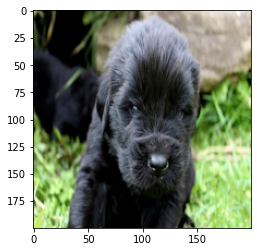

In [9]:
plt.imshow(x[3])

## Make Model:

In [10]:
def printResults(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(["Acc","Val Acc"])
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(["Loss","Val Loss"])
    plt.show()
    plt.plot(history.history['F1_Score'])
    plt.plot(history.history['val_F1_Score'])
    plt.legend(["F1","Val F1"])
    plt.show()


In [11]:
from keras import backend as K

def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
def makeModel():
    model = Sequential()
    model.add(Conv2D(64,kernel_size=(4,4), padding='Same',activation = 'relu', input_shape=imgShape))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(128,kernel_size=(3,3),padding='Same',activation = 'relu'))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(256,kernel_size=(2,2),padding='Same',activation = 'relu'))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(512,kernel_size=(2,2),padding='Same',activation = 'relu'))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(1024,kernel_size=(2,2),padding='Same',activation = 'relu'))
    model.add(MaxPool2D(2,2))
    
    
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(37,activation='softmax'))
    
    print(model.summary())
    
    return model

In [13]:
model = makeModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 128)     6272      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 66, 66, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 66, 66, 256)       131328    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 512)       524800    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 1024)      2

In [15]:
model.compile(optimizer=Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy',F1_Score])

## Train model:

In [16]:
yOneHot.shape

(5878, 37)

In [17]:
y

array([36, 16, 15, ..., 25, 27, 35])

In [18]:
history = model.fit(x,y,validation_split=0.3,verbose=1,epochs=10)

Epoch 1/10
129/129 [==============================] - 42s 244ms/step - loss: 3.6257 - accuracy: 0.0253 - F1_Score: 4.5600e-04 - val_loss: 3.6133 - val_accuracy: 0.0198 - val_F1_Score: 0.0000e+00
Epoch 2/10
129/129 [==============================] - 26s 201ms/step - loss: 3.6114 - accuracy: 0.0216 - F1_Score: 0.0000e+00 - val_loss: 3.6148 - val_accuracy: 0.0215 - val_F1_Score: 0.0000e+00
Epoch 3/10
129/129 [==============================] - 26s 201ms/step - loss: 3.6108 - accuracy: 0.0287 - F1_Score: 0.0000e+00 - val_loss: 3.6159 - val_accuracy: 0.0215 - val_F1_Score: 0.0000e+00
Epoch 4/10
129/129 [==============================] - 26s 201ms/step - loss: 3.6105 - accuracy: 0.0289 - F1_Score: 0.0000e+00 - val_loss: 3.6170 - val_accuracy: 0.0198 - val_F1_Score: 0.0000e+00
Epoch 5/10
129/129 [==============================] - 26s 202ms/step - loss: 3.6104 - accuracy: 0.0263 - F1_Score: 0.0000e+00 - val_loss: 3.6175 - val_accuracy: 0.0198 - val_F1_Score: 0.0000e+00
Epoch 6/10
129/129 [=====

KeyboardInterrupt: 

In [ ]:
printResults(history)

## Try Pre-Trained Models:

In [142]:
from keras.applications.vgg19 import VGG19, preprocess_input

In [50]:
from keras.applications.efficientnet import EfficientNetB7, preprocess_input

In [51]:
baseModel = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(150, 150, 3), pooling='avg')

In [52]:
picsTrain = preprocess_input(x)
picsTrain.shape

(5878, 150, 150, 3)

In [53]:
xtop = baseModel.output
xmid1 = Dense(1024, name='classifier1', activation='relu')(xtop)
'''bn1 = BatchNormalization()(xmid1)
drop1 = Dropout(0.2)(bn1)
xmid2 = Dense(512, name='classifier2', activation='relu')(drop1)
bn2 = BatchNormalization()(xmid2)
drop2 = Dropout(0.2)(bn2)
xmid3 = Dense(128, name='classifier3', activation='relu')(drop2)
bn3 = BatchNormalization()(xmid3)
drop3 = Dropout(0.2)(bn3)'''
xout = Dense(37, name='output', activation='softmax')(xmid1)

# create a model whose input is input of the base model and output is x_out
model = Model(baseModel.input, xout)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 150, 150, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 150, 150, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [54]:
# Train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model 
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics = ['accuracy',F1_Score])

In [55]:
history = model.fit(picsTrain, yOneHot, epochs=15,batch_size=64, validation_split =0.2)

Epoch 1/15
74/74 [==============================] - 57s 506ms/step - loss: 0.9607 - accuracy: 0.7237 - F1_Score: 0.7019 - val_loss: 0.5781 - val_accuracy: 0.8053 - val_F1_Score: 0.8197
Epoch 2/15
74/74 [==============================] - 33s 451ms/step - loss: 0.4096 - accuracy: 0.8641 - F1_Score: 0.8619 - val_loss: 0.5269 - val_accuracy: 0.8240 - val_F1_Score: 0.8281
Epoch 3/15
74/74 [==============================] - 34s 454ms/step - loss: 0.2684 - accuracy: 0.9105 - F1_Score: 0.9073 - val_loss: 0.5899 - val_accuracy: 0.8172 - val_F1_Score: 0.8226
Epoch 4/15
74/74 [==============================] - 34s 456ms/step - loss: 0.2061 - accuracy: 0.9311 - F1_Score: 0.9299 - val_loss: 0.5387 - val_accuracy: 0.8393 - val_F1_Score: 0.8464
Epoch 5/15
74/74 [==============================] - 34s 457ms/step - loss: 0.1669 - accuracy: 0.9434 - F1_Score: 0.9411 - val_loss: 0.6564 - val_accuracy: 0.8070 - val_F1_Score: 0.8097
Epoch 6/15
74/74 [==============================] - 34s 458ms/step - loss: 

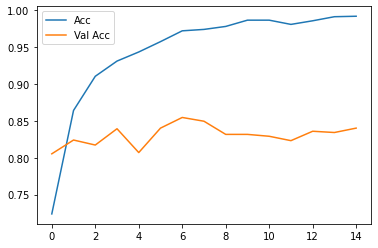

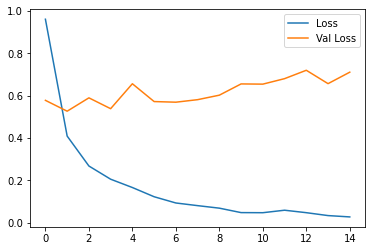

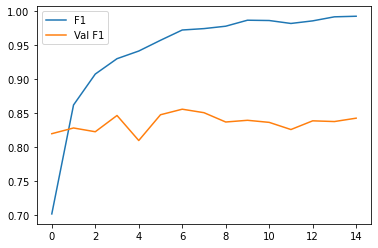

In [56]:
printResults(history)

## Load test data, predict and make csv:

In [28]:
exam= [] #np.array([])
imgShape=(150,150,3)
dirNameTest=r"animal_breed_classification_ai_challenge-dataset/TEST/"

In [29]:
for pic in tqdm(os.listdir(dirNameTest)):
    temp=Image.open(dirNameTest+pic)
    temp=np.array(temp)
    temp=cv2.resize(temp,(150,150))
    exam.append(temp)

exam = np.array(exam)
print(exam.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 149.27it/s]

(1500, 150, 150, 3)


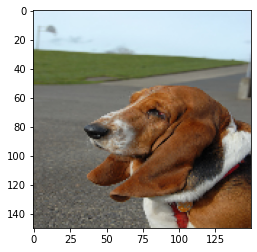

In [30]:
plt.imshow(exam[1000])

In [31]:
examProcessed = preprocess_input(exam)

In [32]:
preds = model.predict(examProcessed)

In [33]:
predNums = [i.argmax() for i in preds]

In [35]:
myfile = open("Attempt 3 EfficientNetB7.csv","w")
myfile.write("Filename,Class\n")
for i in range(len(preds)):
    myfile.write(str(i+1)+".jpg,"+str(numToName[predNums[i]])+"\n")
myfile.close()
print("All Done!")

All Done!


In [36]:
numToName

{0: 'abyssinian',
 1: 'american_bulldog',
 2: 'american_pit_bull_terrier',
 3: 'basset_hound',
 4: 'beagle',
 5: 'bengal',
 6: 'birman',
 7: 'bombay',
 8: 'boxer',
 9: 'british_shorthair',
 10: 'chihuahua',
 11: 'egyptian_mau',
 12: 'english_cocker_spaniel',
 13: 'english_setter',
 14: 'german_shorthaired',
 15: 'great_pyrenees',
 16: 'havanese',
 17: 'japanese_chin',
 18: 'keeshond',
 19: 'leonberger',
 20: 'maine_coon',
 21: 'miniature_pinscher',
 22: 'newfoundland',
 23: 'persian',
 24: 'pomeranian',
 25: 'pug',
 26: 'ragdoll',
 27: 'russian_blue',
 28: 'saint_bernard',
 29: 'samoyed',
 30: 'scottish_terrier',
 31: 'shiba_inu',
 32: 'siamese',
 33: 'sphynx',
 34: 'staffordshire_bull_terrier',
 35: 'wheaten_terrier',
 36: 'yorkshire_terrier'}